In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mtcnn.caffe_pb2 as pb      # protocal buffer
import cv2

In [2]:
net = pb.NetParameter()
with open("mtcnn/det1.caffemodel", "rb") as f:
    net.ParseFromString(f.read())

In [3]:
#net.layer[4]

In [4]:
class BBox:
    # Bounding Box
    def __init__(self, l, t, r, b, confidence=0):
        
        # 这里定义BBox的l、t、r、b是压边的，所以宽高需要r - l + 1、b - t + 1
        # 描述一个框需要4个值，和一个置信度
        self.l = l
        self.t = t
        self.r = r
        self.b = b
        self.confidence = confidence
        
    def iouOf(self, other):
        
        # IoU的计算是交并比
        # 交集怎么求？
        a = self
        b = other
        c_width = min(a.r, b.r) - max(a.l, b.l)
        c_height = min(a.b, b.b) - max(a.t, b.t)
        
        # 这一点非常容易出错
        if c_width <= 0 or c_height <= 0:
            return 0
        
        c_area = c_width * c_height
        return c_area / (a.area + b.area - c_area)
        
    # area
    @property
    def area(self):
        return self.width * self.height
    
    @property
    def left_top(self):
        return int(self.l + 0.5), int(self.t + 0.5)
    
    @property
    def right_bottom(self):
        return int(self.r + 0.5), int(self.b + 0.5)
    
    @property
    def center_x(self):
        return (self.l + self.r) * 0.5
    
    @property
    def center_y(self):
        return (self.t + self.b) * 0.5
    
    @property
    def width(self):
        return self.r - self.l + 1
    
    @property
    def height(self):
        return self.b - self.t + 1
    
    def __repr__(self):
        return f"BBox{{ {self.l}, {self.t}, {self.r}, {self.b}, conf:{self.confidence} }}"
    
    
def nms(objs, iou_threshold):
    
    objs = sorted(objs, key=lambda x:x.confidence, reverse=True)
    
    # 删除的标记
    removed_flags = [False] * len(objs)
    
    # 保留的目标
    keeps = []
    
    for i in range(len(objs)):
        
        # 如果当前i框已经删除，就下一个
        if removed_flags[i]:
            continue
            
        a = objs[i]
        keeps.append(a)
        
        for j in range(i+1, len(objs)):
            
            if removed_flags[j]:
                continue
                
            b = objs[j]
            if a.iouOf(b) > iou_threshold:
                removed_flags[j] = True
                
    return keeps

In [5]:
a = BBox(0, 0, 100, 100, 0.9)
b = BBox(80, 80, 180, 180, 0.98)
#a.iouOf(b)
nms([a, b], 0.01)

[BBox{ 80, 80, 180, 180, conf:0.98 }]

In [6]:
b = BBox(0, 0, 100, 100)
a = BBox(200, 200, 300, 300)
a.iouOf(b)

0

In [7]:
# 定义模块，所有的模块将会继承该基类
class Module:
    def __init__(self):
        self.train_mode = True
        
    def __call__(self, *args):
        return self.forward(*args)
    
    # 训练时
    def train(self):
        self.train_mode = True
        for m in self.modules():
            m.train()
        
    # 评估时，测试时
    def eval(self):
        self.train_mode = False
        for m in self.modules():
            m.eval()
        
    def modules(self):
        ms = []
        for attr in self.__dict__:
            m = self.__dict__[attr]
            if isinstance(m, Module):
                ms.append(m)
        return ms
    
    def params(self):
        ps = []
        for attr in self.__dict__:
            p = self.__dict__[attr]
            if isinstance(p, Parameter):
                ps.append(p)
            
        ms = self.modules()
        for m in ms:
            ps.extend(m.params())
        return ps
    
    def info(self, n):
        ms = self.modules()
        name = self.__class__.__name__
        output = f"{name}\n"
        for m in ms:
            output += ('  '*(n+1)) + f"{m.info(n+1)}\n"
        return output[:-1]
    
    def __repr__(self):
        return self.info(0)
    
    
# 定义参数类，所有需要迭代更新的参数都会继承该类
class Parameter:
    def __init__(self, data):
        self.data = data
        self.grad = np.zeros(data.shape)
        
    def zero_grad(self):
        self.grad[...] = 0


class Linear(Module): 
    def __init__(self, num_input, num_output):
        super().__init__()
        self.weight = Parameter(np.random.normal(0, 1 / np.sqrt(num_input), size=(num_input, num_output)))  # 初始化权重
        self.bias   = Parameter(np.zeros((num_output,)))
    
    def forward(self, x):  # 正向传播
        # save for backward
        self.x = x
        return x @ self.weight.data + self.bias.data
    
    def backward(self, g):  # 反向传播
        self.weight.grad += self.x.T @ g
        self.bias.grad   += np.sum(g, axis=0)
        return g @ self.weight.data.T
    
    
class Sigmoid(Module):  # 定义激活函数对象
    def __init__(self):
        super().__init__()
    
    def sigmoid_impl(self, x):  #定义激活函数 
        return 1 / (1 + np.exp(-x))
    
    def forward(self, x):  # 正向传播
        # save for backward
        self.x = x
        return self.sigmoid_impl(x)
    
    def backward(self, g):  # 反向传播
        return g * self.sigmoid_impl(self.x) * (1 - self.sigmoid_impl(self.x))
    
class Sequencial(Module):
    def __init__(self, *args):
        super().__init__()
        self.items = list(args)
        
    def modules(self):
        return self.items
    
    def forward(self, x):
        for m in self.items:
            x = m(x)
        return x
    
    def backward(self, G):
        for item in self.items[::-1]:
            G = item.backward(G)
        return G
    

class Conv2d(Module):
    def __init__(self, in_feature, out_feature, kernel_size, padding=0, stride=1):
        super().__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        
        fan_mode = kernel_size * kernel_size * in_feature
        self.weight = Parameter(np.random.normal(0, 1 / np.sqrt(fan_mode), size=(out_feature, in_feature, kernel_size, kernel_size)))
        self.bias = Parameter(np.zeros((out_feature)))
        
    def forward(self, x):
        self.in_shape = x.shape
        ib, ic, ih, iw = self.in_shape
        self.oh = (ih + self.padding * 2 - self.kernel_size) // self.stride + 1
        self.ow = (iw + self.padding * 2 - self.kernel_size) // self.stride + 1
        col_w = self.oh * self.ow
        col_h = self.kernel_size * self.kernel_size * self.in_feature
        self.column = np.zeros((ib, col_h, col_w))
        self.output = np.zeros((ib, self.out_feature, self.oh, self.ow))
        khalf = self.kernel_size // 2
        self.kcol = self.weight.data.reshape(self.out_feature, -1)
        for b in range(ib):
            for c in range(ic):
                for oy in range(self.oh):
                    for ox in range(self.ow):
                        for ky in range(self.kernel_size):
                            for kx in range(self.kernel_size):
                                column_y = ky * self.kernel_size + kx + c * self.kernel_size * self.kernel_size
                                column_x = ox + oy * self.ow
                                ix = ox * self.stride + kx - self.padding
                                iy = oy * self.stride + ky - self.padding
                                if ix >= 0 and iy >= 0 and ix < iw and iy < ih:
                                    self.column[b, column_y, column_x] = x[b, c, iy, ix]
            self.output[b] = (self.kcol @ self.column[b]).reshape(self.out_feature, self.oh, self.ow) + self.bias.data.reshape(self.out_feature, 1, 1)
        return self.output
    
    #AB = C  G
    #dB = A.T @ G
    #dA = G @ B.T
    def backward(self, G):
        
        ib, ic, ih, iw = self.in_shape
        for b in range(ib):
            self.weight.grad += (G[b].reshape(self.out_feature, -1) @ self.column[b].T).reshape(self.weight.data.shape)
    
        self.bias.grad += np.sum(G, axis=(0, 2, 3))
        self.Gout = np.zeros((self.in_shape))
        for b in range(ib):
            dcolumn = self.kcol.T @ G[b].reshape(self.out_feature, -1)
            
            # col2im
            for c in range(ic):
                for oy in range(self.oh):
                    for ox in range(self.ow):
                        for ky in range(self.kernel_size):
                            for kx in range(self.kernel_size):
                                column_y = ky * self.kernel_size + kx + c * self.kernel_size * self.kernel_size
                                column_x = ox + oy * self.ow
                                ix = ox * self.stride + kx - self.padding
                                iy = oy * self.stride + ky - self.padding
                                if ix >= 0 and iy >= 0 and ix < iw and iy < ih:
                                    self.Gout[b, c, iy, ix] += dcolumn[column_y, column_x]
        return self.Gout
    
    
class MaxPooling2d(Module):
    def __init__(self, kernel_size=2, stride=2):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride
        
    def forward(self, x):
        ib, ic, ih, iw = x.shape
        oh, ow = int(np.ceil((ih - self.kernel_size) / self.stride) + 1), int(np.ceil((iw - self.kernel_size) / self.stride) + 1)
        output = np.zeros((ib, ic, oh, ow))
        for b in range(ib):
            for c in range(ic):
                for oy in range(oh):
                    for ox in range(ow):
                        ix = ox * self.stride
                        iy = oy * self.stride
                        output[b, c, oy, ox] = x[b, c, iy, ix]
                        
                        for kx in range(self.kernel_size):
                            for ky in range(self.kernel_size):
                                ix = ox * self.stride + kx
                                iy = oy * self.stride + ky
                                if ix < iw and iy < ih:
                                    output[b, c, oy, ox] = max(x[b, c, iy, ix], output[b, c, oy, ox])
        return output
    
    
class ReLU(Module):
    def __init__(self, inplace=True):
        super().__init__()
        self.inplace = inplace
        
    # 亿点点
    def forward(self, x):
        self.negative_position = x < 0
        if not self.inplace:
            x = x.copy()
            
        x[self.negative_position] = 0
        return x
    
    def backward(self, G):
        if not self.inplace:
            G = G.copy()
            
        G[self.negative_position] = 0
        return G
    
class PReLU(Module):
    def __init__(self, num_feature, inplace=False):
        super().__init__()
        self.inplace = inplace
        self.coeff = Parameter(np.zeros((num_feature)))
        
    def forward(self, x):
        if not self.inplace:
            x = x.copy()
            
        for channel in range(x.shape[1]):
            view = x[:, channel]
            negative_position = view < 0
            view[negative_position] *= self.coeff.data[channel]
        return x
    
class Softmax(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        expx = np.exp(x)
        sumx = np.sum(expx, axis=1, keepdims=True)
        return expx / sumx
    
class Flatten(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        self.in_shape = x.shape
        out = x.reshape(self.in_shape[0], -1)
        return out
    
    def backward(self, G):
        return G.reshape(self.in_shape)

In [8]:
def load_conv2d_param(layer_instance : Conv2d, param_data):
    '''
    加载卷积的参数:
    layer_instance[Module]，提供layer的实例对象
    param_data[pb.Parameter]，提供来自于protocalbuffer中加载的数据对象
    '''
    print("加载卷积参数: ", param_data.name)
    conv_weight = layer_instance.weight.data
    conv_bias = layer_instance.bias.data
    
    conv_weight[:] = np.array(param_data.blobs[0].data, dtype=np.float32).reshape(conv_weight.shape)
    conv_bias[:] = np.array(param_data.blobs[1].data, dtype=np.float32).reshape(conv_bias.shape)
    
    
def load_prelu_param(layer_instance, param_data):
    '''
    加载PReLU的参数:
    layer_instance[Module]，提供layer的实例对象
    param_data[pb.Parameter]，提供来自于protocalbuffer中加载的数据对象
    '''
    
    print("加载PReLU参数: ", param_data.name)
    prelu_weight = layer_instance.coeff.data
    prelu_weight[:] = np.array(param_data.blobs[0].data, dtype=np.float32).reshape(prelu_weight.shape)

In [9]:
class PNet(Module):
    def __init__(self, weight_file):
        super().__init__()
        
        self.backbone = Sequencial(
            Conv2d(3, 10, 3),    # conv1
            PReLU(10),           # PReLU1
            MaxPooling2d(2, 2),  
            Conv2d(10, 16, 3),   # conv2
            PReLU(16),           # PReLU2
            Conv2d(16, 32, 3),   # conv3
            PReLU(32)            # PReLU3
        )
        
        self.head_classification = Conv2d(32, 2, 1)  # conv4-1
        self.head_bbox = Conv2d(32, 4, 1)            # conv4-2
        
        # 参数初始化，把weight_file中的权重加载到咱们层中去
        self.load_weight(weight_file)
        
        
    def forward(self, image):
        x       = self.backbone(image)
        classif = self.head_classification(x)
        bbox    = self.head_bbox(x)
        
        expc         = np.exp(classif)
        norm_classif = expc / np.sum(expc, axis=1, keepdims=True)
        return norm_classif, bbox
        
        
    def load_weight(self, weight_file):
        
        net = pb.NetParameter()
        with open(weight_file, "rb") as f:
            net.ParseFromString(f.read())

        state_dict = {item.name : item for item in net.layer}
        
        # 把caffe的权重加载进来
        # 名字为空的表示不需要加载
        layer_names = [
            "conv1", "PReLU1", "", "conv2", "PReLU2", "conv3", "PReLU3", "conv4-1", "conv4-2"
        ]
        
        layer_instances = self.backbone.items + [self.head_classification, self.head_bbox]
        for layer_name, layer_instance in zip(layer_names, layer_instances):
            if layer_name == "":
                continue
            
            param_data = state_dict[layer_name]
            if isinstance(layer_instance, Conv2d):
                load_conv2d_param(layer_instance, param_data)
            elif isinstance(layer_instance, PReLU):
                load_prelu_param(layer_instance, param_data)

In [10]:
pnet = PNet("mtcnn/det1.caffemodel")

加载卷积参数:  conv1
加载PReLU参数:  PReLU1
加载卷积参数:  conv2
加载PReLU参数:  PReLU2
加载卷积参数:  conv3
加载PReLU参数:  PReLU3
加载卷积参数:  conv4-1
加载卷积参数:  conv4-2


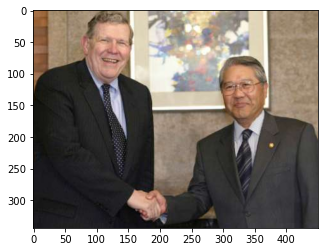

In [11]:
image = cv2.imread("test1.jpg")
plt.imshow(image[..., ::-1])

In [12]:
def pyrdown(image, min_face, max_face, factor=0.709):
    minl = min(image.shape[:2])

    # 大的尺度值，取自min_face
    begin_scale = 12 / min_face
    end_scale = 12 / min(max_face, minl)
    scale = begin_scale
    factor = 0.709

    pyr_images = []
    while scale * minl >= 12 and scale >= end_scale:
        pyr_image = cv2.resize(image, dsize=None, fx=scale, fy=scale)
        pyr_images.append([pyr_image, scale])
        print(scale)
        scale    *= factor
    return pyr_images

In [ ]:
image = cv2.imread("test1.jpg")
pyr_images = pyrdown(image[..., ::-1], 50, 80)
pyr_images
show = pyr_images[0][0].copy()
for i in range(len(pyr_images)):
    
    pyr_image = pyr_images[i][0]
    
    sh, sw = show.shape[:2]
    ph, pw = pyr_image.shape[:2]
    
    show[sh - ph:, sw - pw:] = pyr_image
    
plt.imshow(show)

In [14]:
predicts = []
for image, scale in pyr_images:
    
    itensor = ((image - 127.5) / 128.0).transpose(2, 1, 0)[None].astype(np.float32)
    classif, bbox = pnet(itensor)
    predicts.append([classif, bbox, scale])

In [15]:
# 解析predict
cellsize = 12
stride   = 2
confidence_threshold = 0.6
objs     = []

for classif, bbox, scale in predicts:
    ys, xs = np.where(classif[0, 1] > confidence_threshold)
    for y, x in zip(ys, xs):
        # 遍历每一个正例预测置信度大于阈值的cell
        
        confidence = classif[0, 1, y, x]
        regl = bbox[0, 0, y, x]
        regt = bbox[0, 1, y, x]
        regr = bbox[0, 2, y, x]
        regb = bbox[0, 3, y, x]
        
        # rawimage = 1000, 1000
        # input(14) = rawimage * scale
        # 14 x 14
        #  a  b
        #  c  d
        #
        #  a  c
        #  b  d
        
        # (0, 0)   (0, 1)
        # (1, 0)   (1, 1)
        
        left   = (y * stride + 0 + regl * cellsize) / scale
        top    = (x * stride + 0 + regt * cellsize) / scale
        right  = (y * stride + cellsize - 1 + regr * cellsize) / scale
        bottom = (x * stride + cellsize - 1 + regb * cellsize) / scale
        
        objs.append(BBox(left, top, right, bottom, confidence))
        
objs = nms(objs, 0.6)

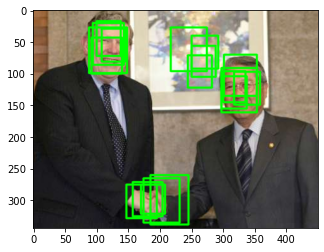

In [16]:
show = cv2.imread("test1.jpg")

for obj in objs:
    cv2.rectangle(show, obj.left_top, obj.right_bottom, (0, 255, 0), 2, 16)

plt.imshow(show[..., ::-1])

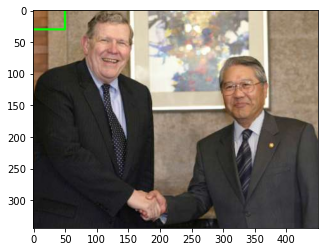

In [25]:
image = cv2.imread("test1.jpg")
obj = BBox(-10, -20, 50, 30)
show = image.copy()
_ = cv2.rectangle(show, obj.left_top, obj.right_bottom, (0, 255, 0), 2, 16)

plt.imshow(show[..., ::-1])

In [26]:
# 另一个小图大小是24x24
# 长边对齐
# 全部扣，多余部分不填充0.填充图像应有的背景

[[ 0.39344262  0.          4.13114754]
 [ 0.          0.39344262 10.03278689]
 [ 0.          0.          1.        ]]


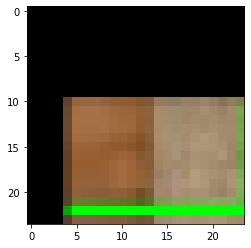

In [27]:


T1 = np.array([
    [1, 0, -obj.center_x],
    [0, 1, -obj.center_y],
    [0, 0, 1]
])

scale = 24 / max(obj.width, obj.height)
S = np.array([
    [scale, 0, 0],
    [0, scale, 0],
    [0, 0, 1]
])

T2 = np.array([
    [1, 0, 24/2],
    [0, 1, 24/2],
    [0, 0, 1]
])
M = T2 @ S @ T1
print(M)
small_image = cv2.warpAffine(show, M[:2], (24, 24))
plt.imshow(small_image[..., ::-1])